<a href="https://colab.research.google.com/github/Abhijit-2592/visualizing_cnns/blob/master/filter_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing the Convolutional Neural Network's filters
The Learnt CNN filters in the initial layers (I prefer to visualize a top down view of the network: input image on the top and output on the bottom in contrast to the widely used bottom up view of the network: input image in the bottom and output on the top) looks like [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter). This is to be expected as the initial layers are responsible for extracting primitive image features like edges, textures etc. As we go deeper into the network this feature extraction becomes more abstract and it tries to extract features like faces, body parts etc. So how do we visualize these filters? Directly visualizing them will not make much sense because, they are just a bunch of 3X3, 5x5 etc matrices. So how can we visualize these learnt filters?

One way to inspect these filters is to display the visual pattern that each filter is meant to respond to. This can be done with gradient **ascent** (yes I mean ascent! and not descent) in input space: applying gradient ascent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a random input image. The resulting input image will be one that the chosen filter is maximally responsive to.

This process is simple. We will build a loss function that maximizes the value of a given filter in a given convolution layer, and then we will use our standard trick **"stochastic gradient descent"** (it's ascent here since we are trying to maximize) to adjust the values of the input image so as to maximize this activation value.

The loss function we will use is just **the mean of that specific filter!**


Reference: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
np.random.seed(500)

In [0]:
%matplotlib inline

In [0]:
print(tf.__version__)
print(np.__version__)

2.1.0
1.17.5


In [0]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

553467904/553467096 [==============================] - 23s 0us/step


In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
layer_name = 'block3_conv1'
filter_index = 0

In [0]:
partial_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)

In [0]:
partial_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


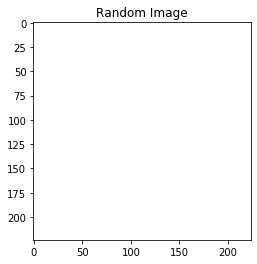

In [0]:
random_image = np.random.random((224, 224, 3)) * 20 + 128
plt.title("Random Image")
plt.imshow(random_image)
plt.show()
random_image = np.expand_dims(random_image, axis=0)  # reshape it to (1,224,224,3)

In [0]:
def get_gradients(model, image, filter_index):
    image_tensor = tf.convert_to_tensor(image, dtype="float32")
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        layer_output = model(image_tensor)
        loss = tf.reduce_mean(layer_output[:, :, :, filter_index])
    grads = tape.gradient(loss, image_tensor)
    return grads

## NOTE:

Here we are using a normalization trick to make the gradient ascent process smooth. We are normalizing the gradients using a scalar that is very similar to it's L2 norm (take the mean before we do the square root). This ensures that our gradients are not too small nor too large

In [0]:
step_size = 1
epochs = 30
progbar = tf.keras.utils.Progbar(epochs)
for i in range(epochs):
    grads = get_gradients(partial_model, random_image, filter_index=filter_index)
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)  # normalization trick
    random_image += grads * step_size   # + is gradient ascent
    progbar.update(i+1)

30/30 [==============================] - 7s 221ms/step


In [0]:
def deprocess_image(x):
    """Utility function to convert a tensor into a valid image
    """
    x = np.squeeze(x.numpy(), axis=0)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
filter_image = deprocess_image(random_image)

In [0]:
filter_image.shape

(224, 224, 3)

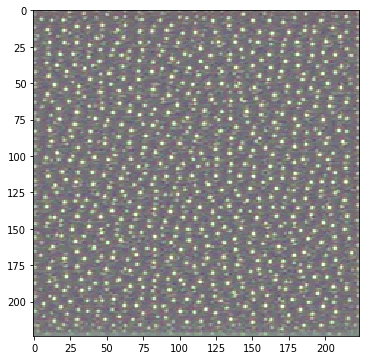

In [0]:
plt.figure(figsize=(6,6))
plt.imshow(filter_image)
plt.show()

Looks like this specific filter responds to **POLKA DOT** like patterns in the input image

## Let's Visualize a bunch of filters now

The following is coded up in such a way that you can pass any layer name and the number of filters you want to visualize from that layer

In [0]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(np.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images

In [0]:
def visualize_single_filter(model, layer_name, filter_index, step_size=1, epochs=30):
    partial_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)
    random_image = np.random.random((224, 224, 3)) * 20 + 128
    random_image = np.expand_dims(random_image, axis=0)  # reshape it to (1,224,224,3),
    for i in range(epochs):
        grads = get_gradients(partial_model, random_image, filter_index=filter_index)
        grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)  # normalization trick
        random_image += grads * step_size   # + is gradient ascent
    return deprocess_image(random_image)

In [0]:
layer_name = 'block1_conv1'
filter_nums = 64
filter_images = []
progbar = tf.keras.utils.Progbar(filter_nums)
for filter_index in range(filter_nums):
    filter_image = visualize_single_filter(model, layer_name, filter_index)
    filter_images.append(filter_image)
    progbar.update(filter_index+1)

64/64 [==============================] - 6s 91ms/step


In [0]:
stitched_image = stitch_images(images=filter_images, margin=5, cols=int(np.sqrt(filter_nums)))

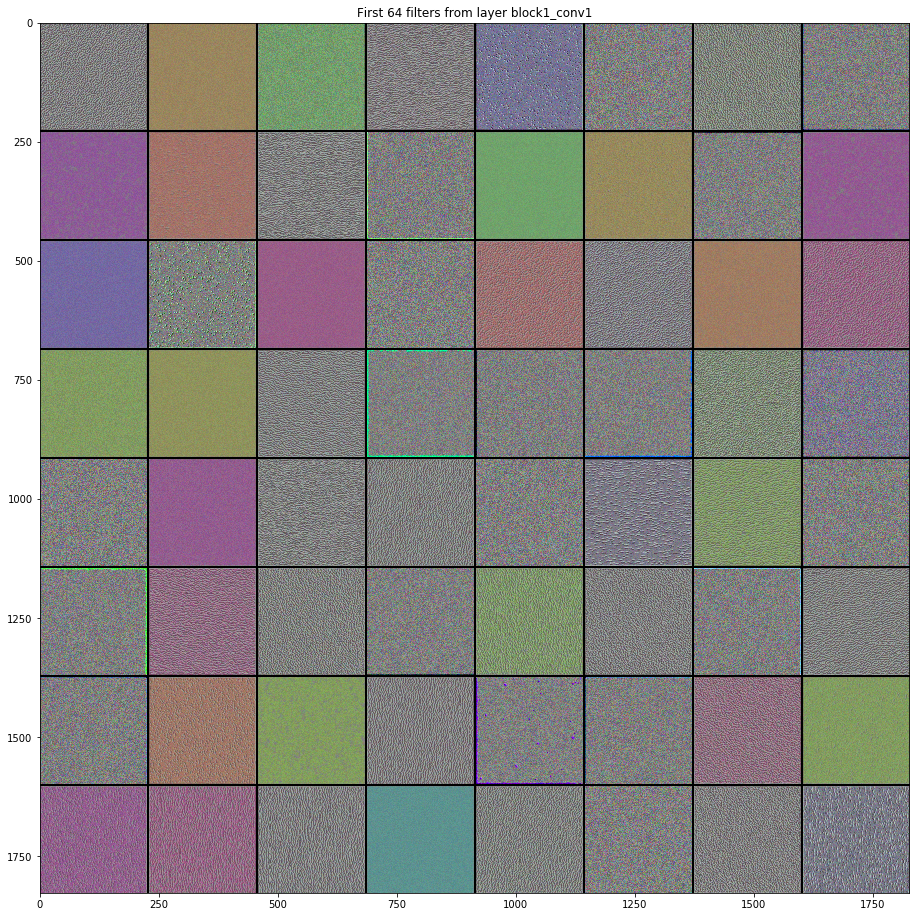

In [0]:
plt.figure(figsize=(16,16))
plt.title("First {} filters from layer {}".format(filter_nums, layer_name))
plt.imshow(stitched_image)
plt.show()

# Inference:
These filter visualizations tell you a lot about how a convolutional neural network sees the world. Each layer in a ConvNet learns a collection of filters such that their inputs can be expressed as a combination of these filters. The filters in these ConvNet layers get increasingly complex and refined as you go higher in the model:

The filters from the first layer in the model ( block1_conv1 ) encode simple directional edges and colors (or colored edges, in some cases).
The filters from block2_conv1 encode simple textures (These are the Gabor like filters as they are responsible for texture extractions) made from combinations of edges and colors.

The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.